# Task 2: In-Modelling
---
---

# Explore XAI techniques on the Student’s Dropout Dataset

**Course:** Advanced Topics in Machine Learning

**Group:** DS2-G3
        
    Alexandre Sousa: 202206427
    Magda Costa: 202207036
    Rafael Pacheco: 202206258

---

---

# Index  <a name = "index"></a>
1. [In-Modelling Techniques](#imt)
    - [Decision Tree](#imt_dt)
        - [Full Decision Trees](#fdt)
        - [Limited Decision Trees](#ldt)

---

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from pygam import LogisticGAM
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
data = pd.read_csv('data_preprocessed.csv')
data_all = pd.read_csv('data_all_preprocessed.csv')

# In-Modelling Techniques <a name = "imt"></a>
[[go back to Index]](#index)

## Decision Tree <a name = "imt_dt"></a>
[[go back to In-Modelling Techniques]](#imt)

Decision Trees are supervised learning algorithms used for both classification and regression tasks. They work by recursively splitting the dataset into smaller subsets based on the values of the input features, aiming to create regions as homogeneous as possible with respect to the target variable. Each internal node of the tree represents a decision rule based on one feature, each branch corresponds to an outcome of that rule, and each leaf node represents a predicted class or value.

Because of this hierarchical, rule-based structure, Decision Trees are considered white-box models. Their decision-making process can be directly observed and interpreted: it is possible to trace the path from the root node to a leaf node to understand precisely why a specific prediction was made. This transparency stands in contrast to black-box models, such as deep neural networks, whose internal logic is much more complex to interpret.

The depth of the tree, that is, the number of levels from the root to the deepest leaf, plays a crucial role in both model performance and explainability. A deeper tree allows the model to capture more complex relationships in the data, potentially improving predictive accuracy. However, it also increases the number of rules and branches, making the model more difficult to interpret and more prone to overfitting. Conversely, a shallower tree produces more straightforward decision rules that are easier to visualise and explain, but may lack predictive power.
Therefore, when building Decision Trees, there is a trade-off between accuracy and interpretability. Limiting the depth helps maintain the model’s transparency and generalisability, while excessive depth may obscure the logic behind decisions and reduce the model’s usefulness as an explanatory tool.

### Full Decision Trees <a name = "fdt"></a>
[[go back to Decision Tre]](#imt_dt)

Let us start by comparing the classification results of the trees trained on the complete data and on the data labeled "Enrolled" to verify whether these instances actually introduce noise and worsen the model's classification.

**All Data**

In [3]:
X_all = data_all.drop('Target', axis=1)  # todas as colunas menos a variável alvo
y_all = data_all['Target']               # variável alvo

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

In [4]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_all, y_train_all)
y_pred_all = model.predict(X_test_all)
acc = accuracy_score(y_test_all, y_pred_all)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.68


In [5]:
with_noLimit_cm = confusion_matrix(y_test_all, y_pred_all)

**Without Enrolled**

In [6]:
X = data.drop('Target', axis=1)  # todas as colunas menos a variável alvo
y = data['Target']               # variável alvo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.86


In [8]:
without_noLimit_cm = confusion_matrix(y_test, y_pred)

**Comparison With and Without Enrolled**

In [9]:
# Comparison with no limits setup
def metricsCollection(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro"),
        "Precision_macro": precision_score(y_true, y_pred, average="macro"),
        "Recall_macro": recall_score(y_true, y_pred, average="macro")
    }

metrics_before = metricsCollection(y_test_all, y_pred_all)
metrics_after  = metricsCollection(y_test,  y_pred)

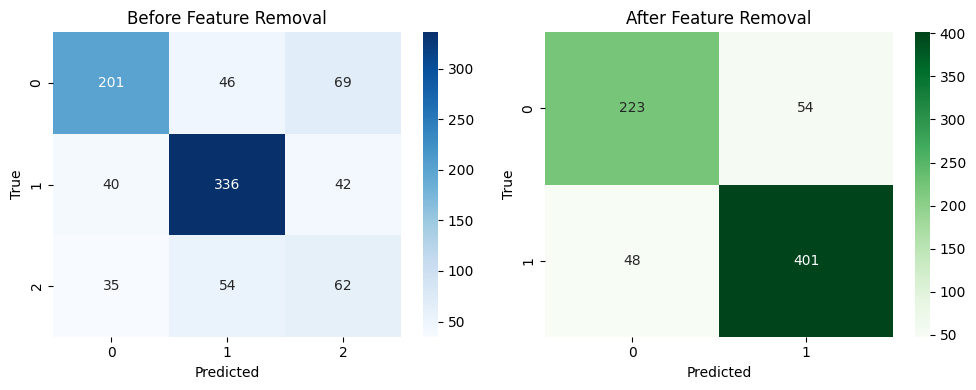

                 Before  After
Accuracy          0.677  0.860
F1_macro          0.616  0.851
Precision_macro   0.619  0.852
Recall_macro      0.617  0.849


In [10]:
"""
 Creates plots and prints values for decision tree comparison.
"""

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(with_noLimit_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Before Feature Removal")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(without_noLimit_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("After Feature Removal")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

comparison = pd.DataFrame([metrics_before, metrics_after], index=["Before", "After"]).T
print(comparison.round(3))

As we can see, **removing the `Enrolled` label significantly improved the model's performance**. Therefore, **from this point on**, we will **always use the dataset without this label information**, and thus eliminating it.

Let us now look at the decision tree that has been created; it is expected to be very difficult to understand, as it is quite deep.

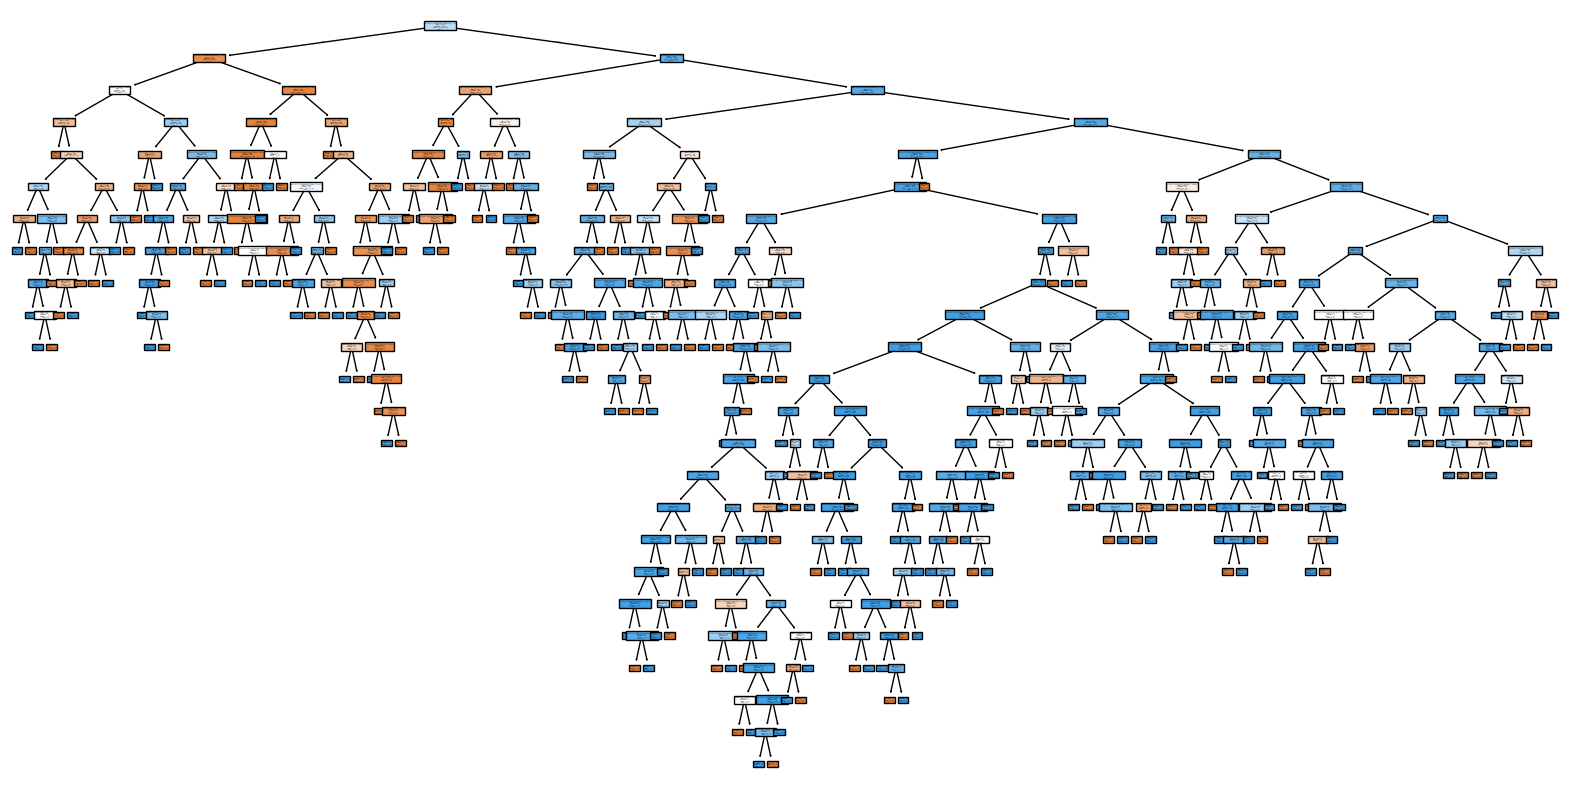

In [11]:
plt.figure(figsize=(20,10))
plot_tree(
    model, 
    filled=True, 
    feature_names=X.columns, 
    class_names=[str(c) for c in model.classes_]
)
plt.show()

As expected, the generated decision tree is difficult to understand, so we will retrain the model by limiting its depth.

### Limited Decision Trees <a name = "ldt"></a>
[[go back to Decision Tree]](#imt_dt)

**With Enrolled**

In [12]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train_all, y_train_all)
y_pred_all = model.predict(X_test_all)
acc = accuracy_score(y_test_all, y_pred_all)
print(f"Accuracy: {acc:.2f}")

with_limited_cm = confusion_matrix(y_test_all, y_pred_all) 

Accuracy: 0.72


**Without Enrolled**

In [13]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

without_limited_cm = confusion_matrix(y_test, y_pred) 

Accuracy: 0.89


**Comparison With and Without Enrolled**

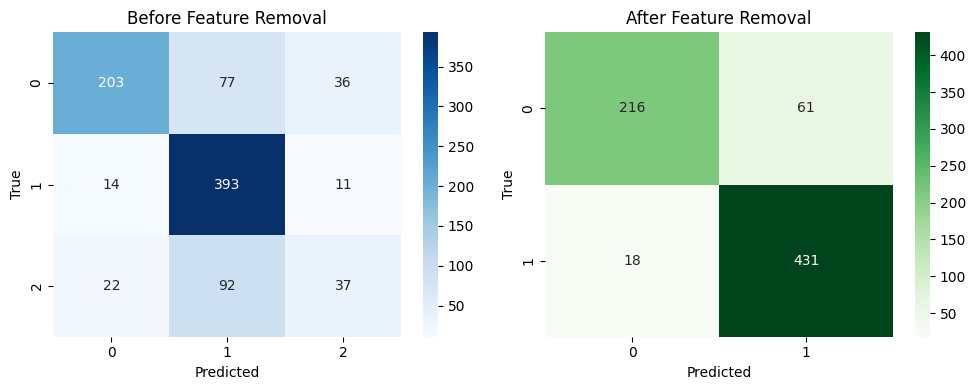

                 Before  After
Accuracy          0.677  0.860
F1_macro          0.616  0.851
Precision_macro   0.619  0.852
Recall_macro      0.617  0.849


In [14]:
"""
 Creates plots and prints values for decision tree comparison.
"""

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(with_limited_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Before Feature Removal")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(without_limited_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("After Feature Removal")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

comparison = pd.DataFrame([metrics_before, metrics_after], index=["Before", "After"]).T
print(comparison.round(3))

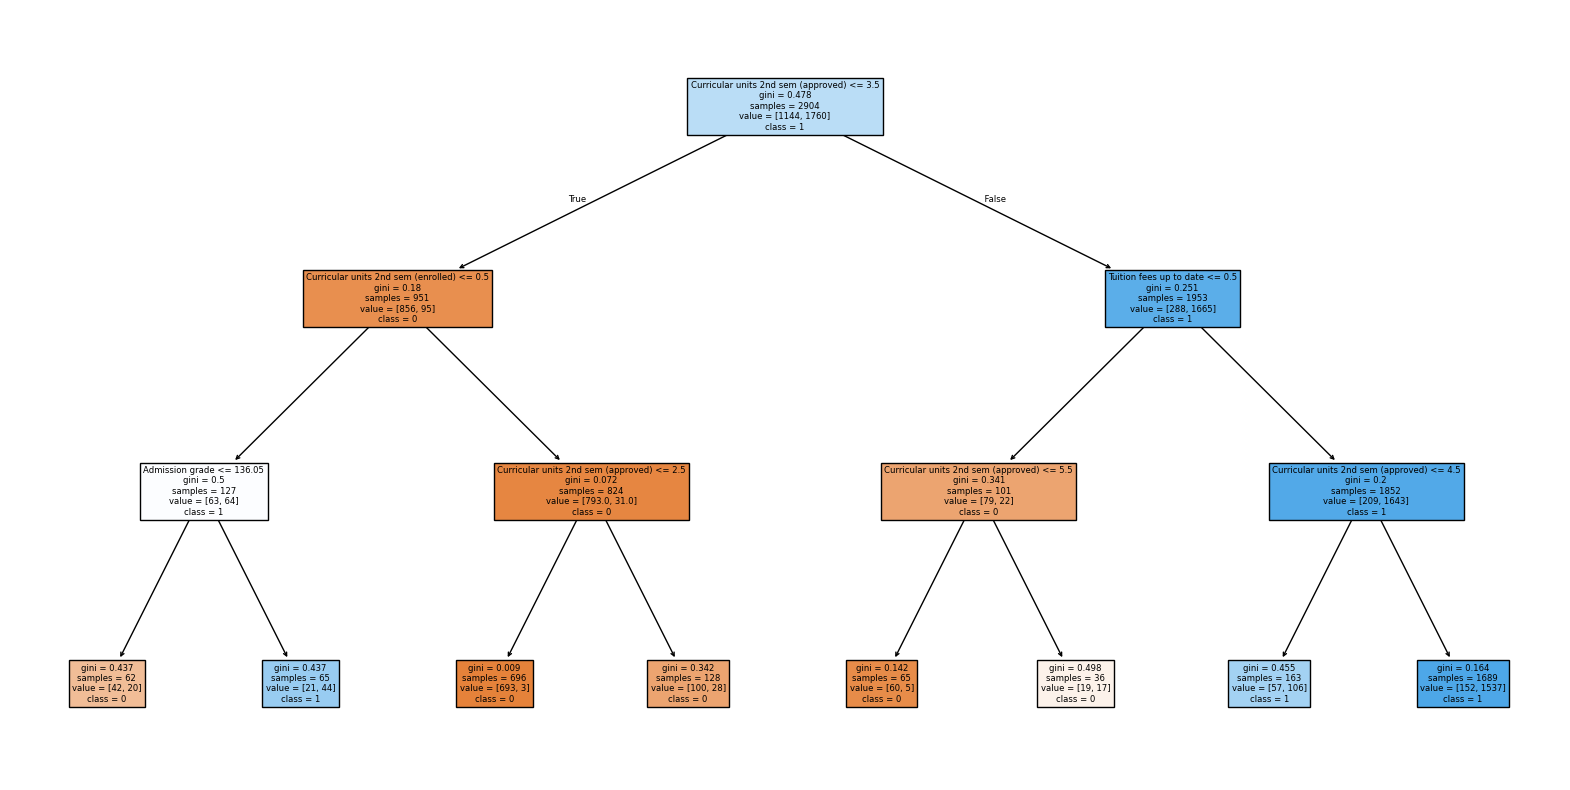

In [15]:
plt.figure(figsize=(20,10))
plot_tree(
    model, 
    filled=True, 
    feature_names=X.columns, 
    class_names=[str(c) for c in model.classes_]
)
plt.show()

As can be seen, the model has become much clearer, and, as previously observed, the most relevant features do indeed prove to be so. We conclude that the decision tree highly values ​​the features:
- Curricular units 2nd sem (approved)
- Curricular units 2nd term (enrolled)
- Tuition fees up to date

For these reasons, we chose to preserve the parameters and simplifications above and use the Decision Tree as our glass box model.